<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Поиск токсичных комментариев

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. В нашем распоряжении набор данных с разметкой о токсичности правок.

# Цели исследования

Обучить модель классифицировать комментарии на позитивные и негативные. Построить модель со значением метрики качества *F1* не меньше 0.75. 

# Описание данных

- `text` — текст комментария
- `toxic` — является ли комментарий токсичным (1 или 0)

# Этапы исследования
1.   Подготовка данных
2.   Обучение моделей
3.   Выводы

## Подготовка данных

In [ ]:
# импортируем необходимые библиотеки

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import spacy
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, roc_curve, confusion_matrix

In [ ]:
# сохраним данные в переменной data

data = pd.read_csv('***')

In [ ]:
# выведем первые 5 строк датасета

data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
# общая информация о данных

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [ ]:
# проверим наличие дубликатов

data.duplicated().sum()

0

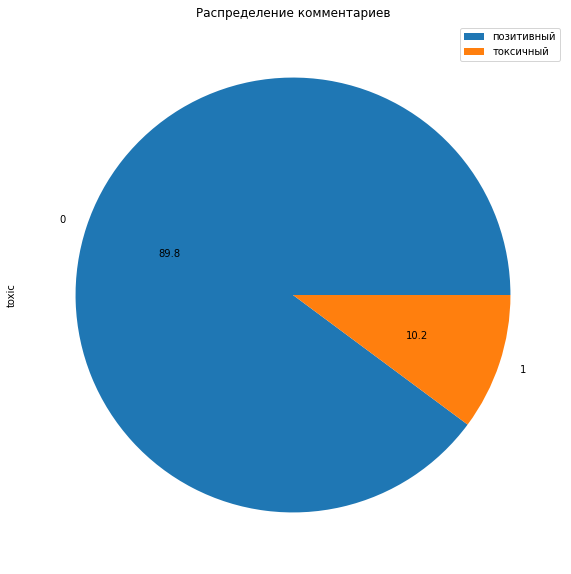

In [ ]:
# построим график распределения классов комметариев

data['toxic'].value_counts().plot(kind='pie', autopct='%.1f', figsize=(10,10))
plt.legend(['позитивный','токсичный'])
plt.title('Распределение комментариев');

Видим дисбаланс классов. Это необходимо будет учесть при обучении моделей.

In [ ]:
# напишем функцию для очистки и лемматизации текста

nlp = spacy.load('en_core_web_sm')
regex = re.compile(r'[^a-zA-Z]')

def lemmatize_and_clear_text(text):
    doc = nlp(text)
    lem_text = [token.lemma_.lower() for token in doc if token.is_alpha]
    text_out = ' '.join(lem_text)
    text_out = regex.sub(' ', text_out)
    return text_out

In [ ]:
# добавим новую колонку с лемматизированным очищенным текстом

data['text_lemm'] = data['text'].apply(lemmatize_and_clear_text)

In [ ]:
data.head()

,Unnamed: 0,text,toxic,text_lemm
0,0,Explanation\nWhy the edits made under my usern...,0,explanation why the edit make under my usernam...
1,1,D'aww! He matches this background colour I'm s...,0,he match this background colour i seemingly st...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man i really not try to edit war it just t...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,more i can make any real suggestion on improve...
4,4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


**Вывод**

Пропусков и дублей нет. Есть дисбаланс классов (90% нетоксичных комментариев). Добавили колонку с лемматизированным текстом.

## Обучение моделей

Разделим данные на тренирововчную и тестовую выборки.

In [ ]:
train, test = train_test_split(data, test_size=0.25, stratify=data['toxic'], random_state=12345)

In [ ]:
features_train = train['text_lemm']
target_train = train['toxic']

features_test = test['text_lemm']
target_test = test['toxic']

In [ ]:
# создадим переменную с английскими стоп-словами

stopwords = set(stopwords.words('english'))

In [ ]:
# создадим счётчик величин TF-IDF

count_tf_idf = TfidfVectorizer(stop_words=stopwords, ngram_range=(1,2))

In [ ]:
# посчитаем TF-IDF для всех подвыборок

features_train_vector = count_tf_idf.fit_transform(features_train)
features_test_vector = count_tf_idf.transform(features_test)

In [ ]:
# напишем фунцию для обучения и оценки моделей

def model_estimator(model, params, features_train, target_train, title=None):
    model = RandomizedSearchCV(model, params, cv=5, scoring='f1', n_jobs=-1)
    model.fit(features_train, target_train)
    print(f'Лучшие гиперпараметры {title}:', model.best_params_)
    print('F1 на тренировочной выборке', model.best_score_)

In [ ]:
# обучим логистическую регрессию

logreg = LogisticRegression(random_state=12345)
logreg_params = {'class_weight':['balanced', None], 'max_iter':[500,1000], 'C':[1.0, 3.0]}
model_estimator(logreg, logreg_params,features_train_vector,\
                target_train, 'Логистической регрессии')

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшие гиперпараметры Логистической регрессии: {'max_iter': 500, 'class_weight': 'balanced', 'C': 3.0}
F1 на тренировочной выборке 0.7750666858342783


In [ ]:
# обучим стохастический градиентный спуск

sgd = SGDClassifier(random_state=12345, loss='log')
sgd_params = {'class_weight':['balanced', None], 'max_iter':[500,1000]}
model_estimator(sgd, sgd_params,features_train_vector,\
                target_train, 'Cтохастического градиентного спуска')

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшие гиперпараметры Cтохастического градиентного спуска: {'max_iter': 500, 'class_weight': 'balanced'}
F1 на тренировочной выборке 0.7051087750538471


Лучший результат на тренировочной и валидационной выборках показала логистическая регрессия.

In [ ]:
# протестируем лучшую модель

logreg = LogisticRegression(class_weight='balanced', max_iter=500, C=3.0, random_state=12345)
logreg.fit(features_train_vector, target_train)
predictions = logreg.predict(features_test_vector)
print('F1 на тестовой выборке', f1_score(target_test, predictions))

F1 на тестовой выборке 0.7777388869443472


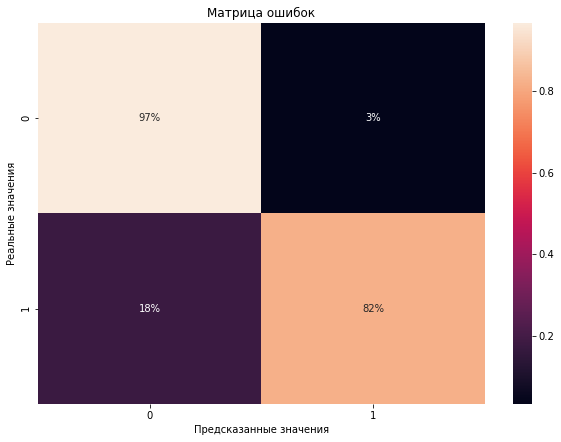

In [ ]:
# построим матрицу ошибок

plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(target_test, predictions, normalize='true'), annot=True, fmt='.0%')
plt.title('Матрица ошибок')
plt.ylabel('Реальные значения')
plt.xlabel('Предсказанные значения');

**Вывод**

Лучше всего на тестовой выборке справилась Логистическая регрессия. Как видим, показатель F1 на тестовой выборке удовлетворяет заявленным требованиям (0.77).

## Общий вывод

Качество исходных данных хорошее: ни пропусков, ни дублей. Но есть заметный дисбаланс классов: 90% нетоксичных комментариев. Учли его при обучении моделей. Лучше всех на тестовой выборке справилась Логистическая регрессия с гиперпараметрами `class_weight`= `'balanced'`, `max_iter`=500 и `C`=3.0. Её результат (F1 = 0.77) удовлетворяет заявленным требованиям к качеству модели. Данная модель рекомендуется заказчику для классификации тона комментариев.